# Full calculation of matter TT temperature correlations $C_l$ and matter power spectrum $P_k$
## Notebook used in the discussion session of Week 8

This notebook uses the excellent [CLASS](http://class-code.net/) code to do a full realistic calculation CMB in the Early Universe

<div>
<p>Experimental data from observations allow to measure CMB temperature correlations and matter power spectrum</p>
<img src="http://www.hep.manchester.ac.uk/u/bezrukov/EarlyUniverse/notes/images/TTspec.png" width="50%"/><img src="http://www.hep.manchester.ac.uk/u/bezrukov/EarlyUniverse/notes/images/Planck_2018_Linear_Matter_Power_Spectrum-1.svg" width="50%" />
</div>

In [85]:
%%bash
# This cell installs CLASS. Ignore the warnings it produces!
if ! python3 -c "import classy" 2>/dev/null; then
    git clone --depth=1 -b v3.0.1 https://github.com/lesgourg/class_public.git
    cd class_public
    PYTHON=python3 make -j all >/dev/null
fi

In [86]:
from classy import Class

In [87]:
from math import pi
import numpy as np
from scipy.optimize import fsolve
from scipy.interpolate import interp1d

In [88]:
%matplotlib inline
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

In [89]:
# create instance of the class "Class"
LambdaCDM = Class()

Prepare the list to store the parameters and results of each simulations

In [90]:
kk_h = np.logspace(-4,np.log10(3.5),1000) # list of k in h/Mpc
simulations = []

In [91]:
## Runs simulations for given parameter set and stores the result in pars and Pk
def run_Class(pp):
    LambdaCDM.struct_cleanup()
    LambdaCDM.empty()
    LambdaCDM.set(pp)
    LambdaCDM.set({'output':'tCl,pCl,lCl,mPk', 'lensing':'yes', 'P_k_max_1/Mpc':kk_h[-1]})
    LambdaCDM.compute()
    # Get Cl
    cls = LambdaCDM.lensed_cl(2500)
    l = cls['ell'][2:] # Values of l, dropping monopole and dipole
    tt = cls['tt'][2:] # Values of C_l for TT correlations
    # get P(k) at redhsift z=0
    Pk = [] # P(k) in (Mpc/h)**3
    h = LambdaCDM.h() # get reduced Hubble for conversions to 1/Mpc
    for k_h in kk_h:
        Pk.append(LambdaCDM.pk(k_h*h, 0.)*h**3) # function .pk(k,z)
    return (LambdaCDM.pars, l, tt, Pk)

In [92]:
LambdaCDM.struct_cleanup()
LambdaCDM.empty()
LambdaCDM.set({
        "T_cmb": 2.7255,        # CMB temperature
        "h": 0.6732117,         # Dimensionless reduced Hubble parameter (H_0 / (100km/s/Mpc))
        "omega_b": 0.02238280,  # Reduced baryon density (Omega*h^2)
        "omega_cdm": 0.1201075, # Reduced cold dark matter density (Omega*h^2)
        'Omega_k': 0.0,         # Curvature density
        'tau_reio':0.05430842,  # Optical depth of reionization
        'A_s': 2.215e-9,        # Amplitude of prim spectrum
        'n_s': 0.9619,          # Spectrum tilt
        'k_pivot': 0.05,         # Pivot scale for A_s,n_s

        # Take fixed value for primordial Helium (instead of automatic BBN adjustment)
                   'YHe':0.246,
})
LambdaCDM.set({'output':'tCl,pCl,lCl,mPk', 'lensing':'yes', 'P_k_max_1/Mpc':kk_h[-1]})
LambdaCDM.compute()

In [93]:
LambdaCDM.h()

0.6732117

In [94]:
LambdaCDM.Omega_Lambda()

0.6855081086250263

Run simulations and add to the `simulations` list. Here we have the default CDM parameters.

Note, $\Omega_\Lambda$ is calculated automatically to satisfy
$$
\Omega_b+\Omega_{cdm}+\Omega_{rad}+\Omega_k = 1
$$
See the (extremely) complete list of possible cosmologicla parameters in [explanatory.ini](https://github.com/lesgourg/class_public/blob/master/explanatory.ini) of the [CLASS](http://class-code.net/) package, and references to original publications.

By convention `omega_cdm` is defined as $\Omega_{cdm}h^2$ (and similar). Note also that $\Omega_\gamma h^2$ and not $\Omega_{rad}$ is used as the input here.

This sets `simulation0` to the 'real world' simulation

In [95]:
simulations0=(
    run_Class({
        "T_cmb": 2.7255,        # CMB temperature
        "h": 0.6732117,         # Dimensionless reduced Hubble parameter (H_0 / (100km/s/Mpc))
        "omega_b": 0.02238280,  # Reduced baryon density (Omega*h^2)
        "omega_cdm": 0.1201075, # Reduced cold dark matter density (Omega*h^2)
        'Omega_k': 0.0,         # Curvature density
        'tau_reio':0.05430842,  # Optical depth of reionization
        'A_s': 2.215e-9,        # Amplitude of prim spectrum
        'n_s': 0.9619,          # Spectrum tilt
        'k_pivot': 0.05         # Pivot scale for A_s,n_s
}) )

## Varying $n_s$

In [96]:
simulations = []

In [97]:
simulations.append(
    run_Class({
        "T_cmb": 2.7255,        # CMB temperature
        "h": 0.6732117,         # Dimensionless reduced Hubble parameter (H_0 / (100km/s/Mpc))
        "omega_b": 0.02238280,  # Reduced baryon density (Omega*h^2)
        "omega_cdm": 0.1201075, # Reduced cold dark matter density (Omega*h^2)
        'Omega_k': 0.0,         # Curvature density
        'tau_reio':0.05430842,  # Optical depth of reionization
        'A_s': 2.215e-9,        # Amplitude of prim spectrum
        'n_s': 1,          # Spectrum tilt
        'k_pivot': 0.05         # Pivot scale for A_s,n_s
}) )

In [98]:
simulations.append(
    run_Class({
        "T_cmb": 2.7255,        # CMB temperature
        "h": 0.6732117,         # Dimensionless reduced Hubble parameter (H_0 / (100km/s/Mpc))
        "omega_b": 0.02238280,  # Reduced baryon density (Omega*h^2)
        "omega_cdm": 0.1201075, # Reduced cold dark matter density (Omega*h^2)
        'Omega_k': 0.0,         # Curvature density
        'tau_reio':0.05430842,  # Optical depth of reionization
        'A_s': 2.215e-9,        # Amplitude of prim spectrum
        'n_s': 0.9,          # Spectrum tilt
        'k_pivot': 0.05         # Pivot scale for A_s,n_s
}) )

Plot the results!

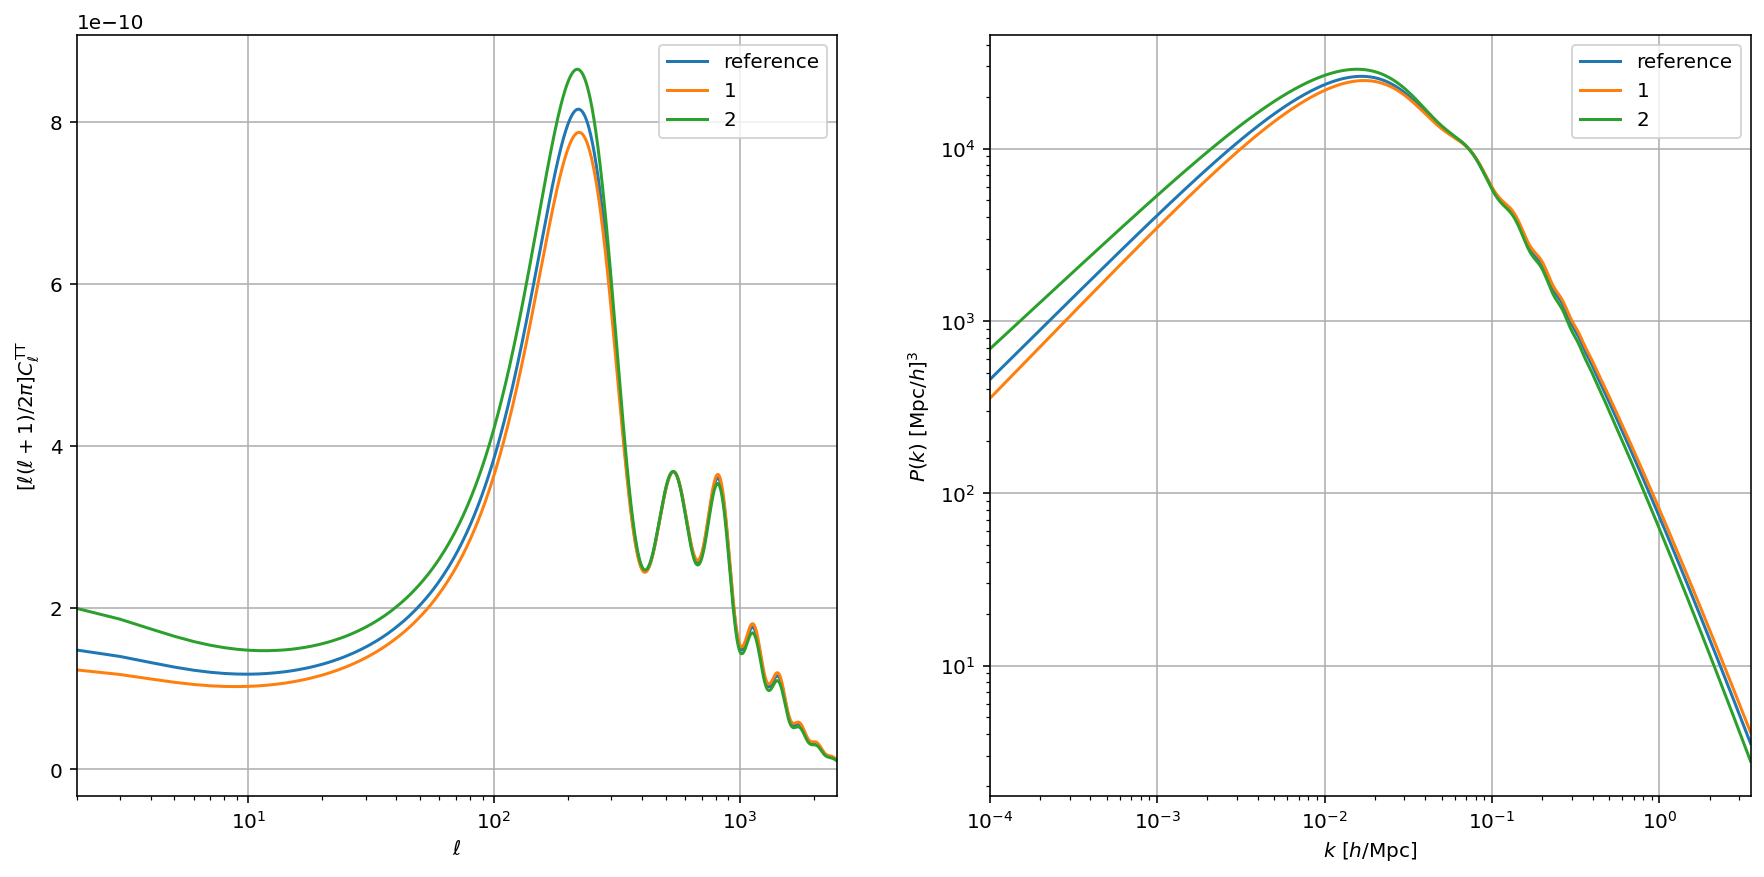

In [99]:
plt.rcParams['figure.figsize'] = (15, 7);

fig, (axCl, axPk) = plt.subplots(1, 2);

axCl.set_xlabel(r'$\ell$')
axCl.set_ylabel(r'$[\ell(\ell+1)/2\pi]  C_\ell^\mathrm{TT}$')
axCl.grid()
axCl.set_xlim(2,2500)

pars0, l0, tt0, Pk0 = simulations0
axCl.semilogx(l0, (tt0)*l0*(l0+1)/2./pi,
                label="reference")
i=1
for pars, l, tt, Pk in simulations:
    axCl.semilogx(l, (tt)*l*(l+1)/2./pi,
                label="%d"%(i))
    i=i+1
#    plt.semilogx(l, tt*l*(l+1)/2./pi,
#                 label="$\Omega_{CDM}=%4.2gh^{-2}, \Omega_b=%4.2gh^{-2}, \Omega_\gamma=%4.2gh^{-2}, \Omega_k=%4.2g, n_s=%4.2g$"%(
#                     pars['omega_cdm'], pars['omega_b'], pars['omega_g'], pars['Omega_k'], pars['n_s']))
axCl.legend()


axPk.set_xlim(kk_h[0], kk_h[-1])
axPk.set_xlabel(r'$k\ [h/\mathrm{Mpc}]$')
axPk.set_ylabel(r'$P(k)\ [\mathrm{Mpc}/h]^3$')
axPk.grid()

pars0, l0, tt0, Pk0 = simulations0
axPk.loglog(kk_h, Pk0, label="reference")
i=1
for pars, l, tt, Pk in simulations:
    axPk.loglog(kk_h, Pk,
                label="%d"%(i))
    i=i+1
#               label="$\Omega_{CDM}=%4.2gh^{-2}, \Omega_b=%4.2gh^{-2}, \Omega_\gamma=%4.2gh^{-2}, \Omega_k=%4.2g, n_s=%4.2g$"%(
#                      pars['omega_cdm'], pars['omega_b'], pars['omega_g'], pars['Omega_k'], pars['n_s']))
axPk.legend()

## Varying $\tau$

In [100]:
simulations = []

In [101]:
simulations.append(
    run_Class({
        "T_cmb": 2.7255,        # CMB temperature
        "h": 0.6732117,         # Dimensionless reduced Hubble parameter (H_0 / (100km/s/Mpc))
        "omega_b": 0.02238280,  # Reduced baryon density (Omega*h^2)
        "omega_cdm": 0.1201075, # Reduced cold dark matter density (Omega*h^2)
        'Omega_k': 0.0,         # Curvature density
        'tau_reio':0.08,  # Optical depth of reionization
        'A_s': 2.215e-9,        # Amplitude of prim spectrum
        'n_s': 0.9619,          # Spectrum tilt
        'k_pivot': 0.05         # Pivot scale for A_s,n_s
}) )

In [102]:
simulations.append(
    run_Class({
        "T_cmb": 2.7255,        # CMB temperature
        "h": 0.6732117,         # Dimensionless reduced Hubble parameter (H_0 / (100km/s/Mpc))
        "omega_b": 0.02238280,  # Reduced baryon density (Omega*h^2)
        "omega_cdm": 0.1201075, # Reduced cold dark matter density (Omega*h^2)
        'Omega_k': 0.0,         # Curvature density
        'tau_reio':0.04,  # Optical depth of reionization
        'A_s': 2.215e-9,        # Amplitude of prim spectrum
        'n_s': 0.9619,          # Spectrum tilt
        'k_pivot': 0.05         # Pivot scale for A_s,n_s
}) )

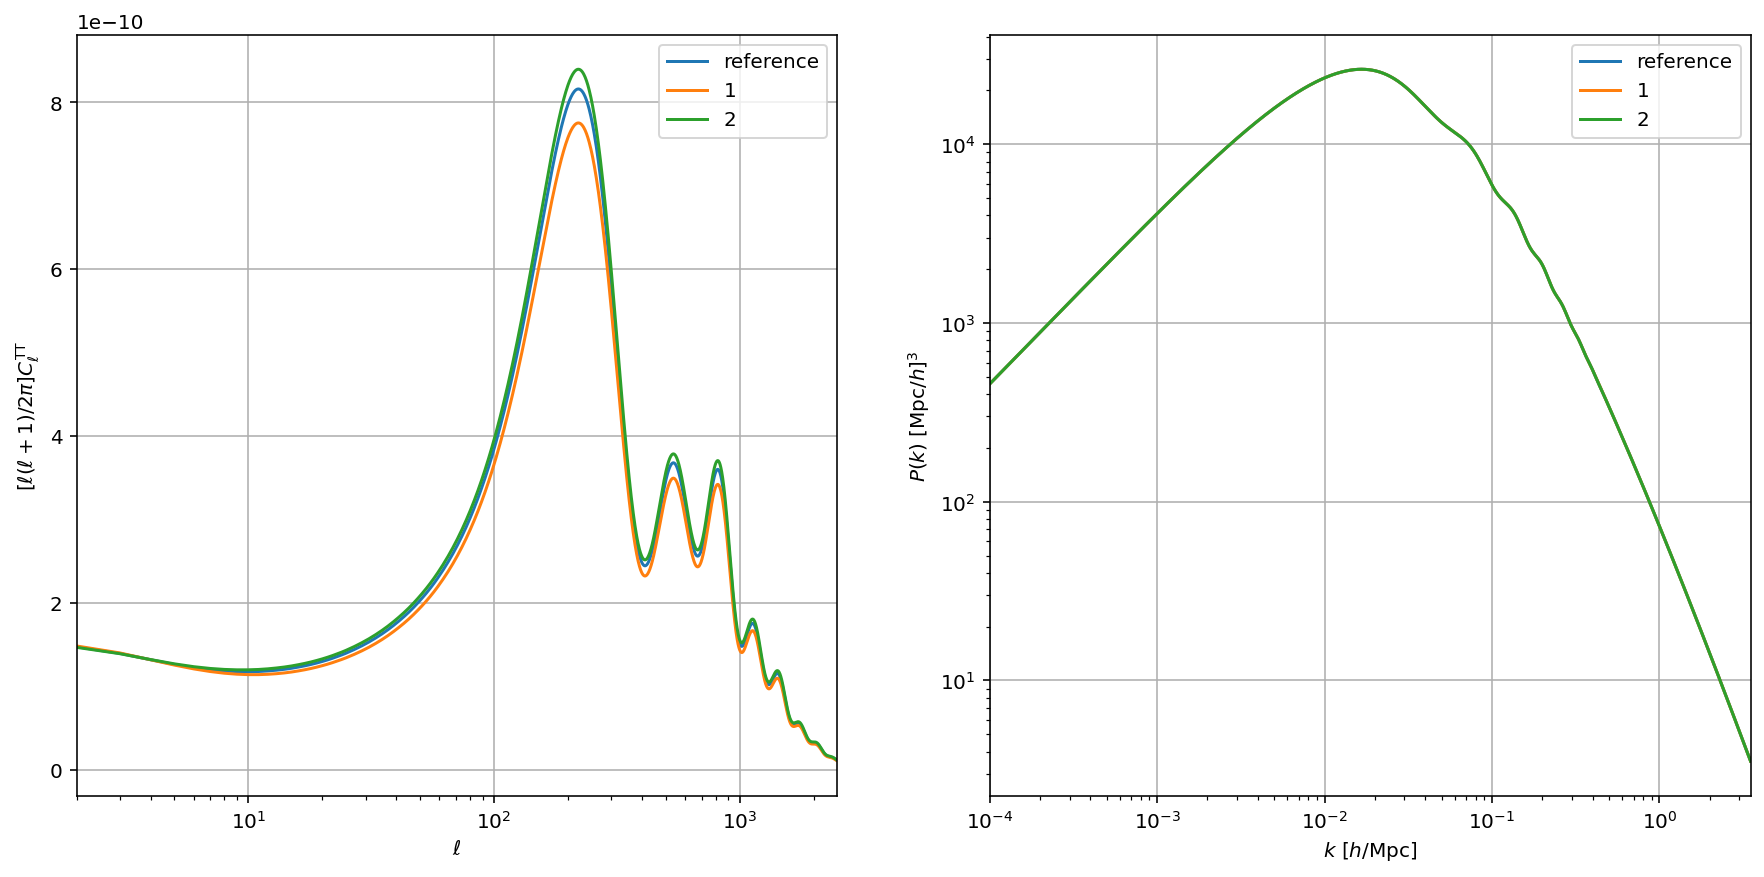

In [103]:
plt.rcParams['figure.figsize'] = (15, 7);

fig, (axCl, axPk) = plt.subplots(1, 2);

axCl.set_xlabel(r'$\ell$')
axCl.set_ylabel(r'$[\ell(\ell+1)/2\pi]  C_\ell^\mathrm{TT}$')
axCl.grid()
axCl.set_xlim(2,2500)

pars0, l0, tt0, Pk0 = simulations0
axCl.semilogx(l0, (tt0)*l0*(l0+1)/2./pi,
                label="reference")
i=1
for pars, l, tt, Pk in simulations:
    axCl.semilogx(l, (tt)*l*(l+1)/2./pi,
                label="%d"%(i))
    i=i+1
#    plt.semilogx(l, tt*l*(l+1)/2./pi,
#                 label="$\Omega_{CDM}=%4.2gh^{-2}, \Omega_b=%4.2gh^{-2}, \Omega_\gamma=%4.2gh^{-2}, \Omega_k=%4.2g, n_s=%4.2g$"%(
#                     pars['omega_cdm'], pars['omega_b'], pars['omega_g'], pars['Omega_k'], pars['n_s']))
axCl.legend()


axPk.set_xlim(kk_h[0], kk_h[-1])
axPk.set_xlabel(r'$k\ [h/\mathrm{Mpc}]$')
axPk.set_ylabel(r'$P(k)\ [\mathrm{Mpc}/h]^3$')
axPk.grid()

pars0, l0, tt0, Pk0 = simulations0
axPk.loglog(kk_h, Pk0, label="reference")
i=1
for pars, l, tt, Pk in simulations:
    axPk.loglog(kk_h, Pk,
                label="%d"%(i))
    i=i+1
#               label="$\Omega_{CDM}=%4.2gh^{-2}, \Omega_b=%4.2gh^{-2}, \Omega_\gamma=%4.2gh^{-2}, \Omega_k=%4.2g, n_s=%4.2g$"%(
#                      pars['omega_cdm'], pars['omega_b'], pars['omega_g'], pars['Omega_k'], pars['n_s']))
axPk.legend()

## Varying $\Omega_k$

In [104]:
simulations = []

In [105]:
simulations.append(
    run_Class({
        "T_cmb": 2.7255,        # CMB temperature
        "h": 0.6732117,         # Dimensionless reduced Hubble parameter (H_0 / (100km/s/Mpc))
        "omega_b": 0.02238280,  # Reduced baryon density (Omega*h^2)
        "omega_cdm": 0.1201075, # Reduced cold dark matter density (Omega*h^2)
        'Omega_k': 0.1,         # Curvature density
        'tau_reio':0.05430842,  # Optical depth of reionization
        'A_s': 2.215e-9,        # Amplitude of prim spectrum
        'n_s': 0.9619,          # Spectrum tilt
        'k_pivot': 0.05         # Pivot scale for A_s,n_s
}) )

In [106]:
simulations.append(
    run_Class({
        "T_cmb": 2.7255,        # CMB temperature
        "h": 0.6732117,         # Dimensionless reduced Hubble parameter (H_0 / (100km/s/Mpc))
        "omega_b": 0.02238280,  # Reduced baryon density (Omega*h^2)
        "omega_cdm": 0.1201075, # Reduced cold dark matter density (Omega*h^2)
        'Omega_k': -0.1,         # Curvature density
        'tau_reio':0.05430842,  # Optical depth of reionization
        'A_s': 2.215e-9,        # Amplitude of prim spectrum
        'n_s': 0.9619,          # Spectrum tilt
        'k_pivot': 0.05         # Pivot scale for A_s,n_s
}) )

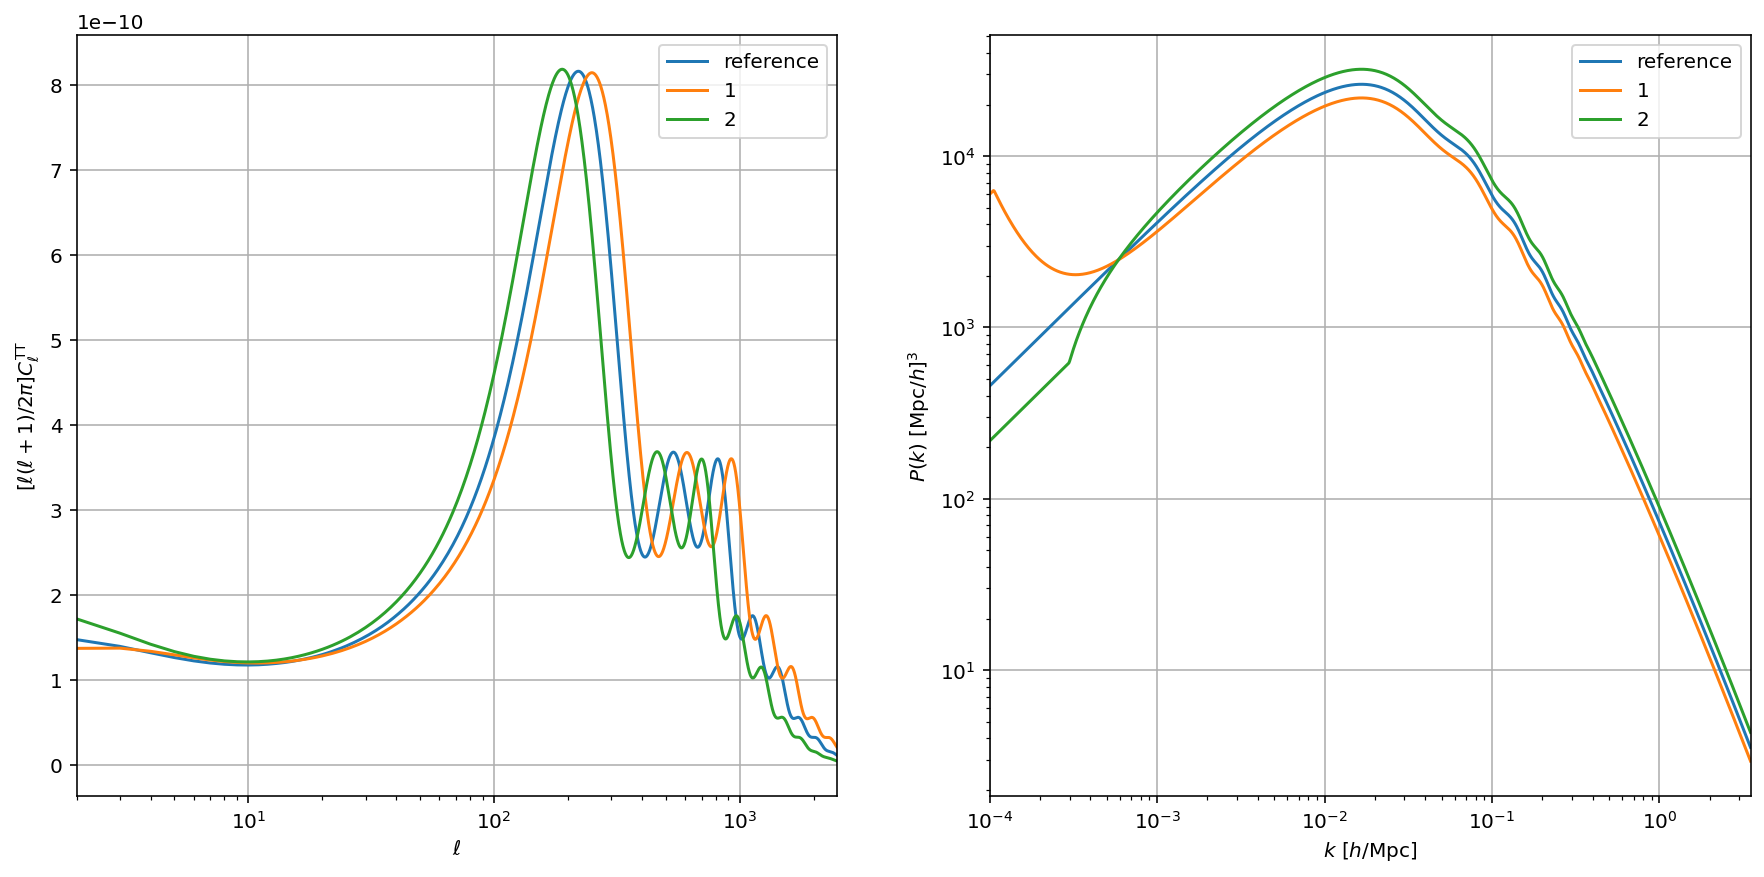

In [107]:
plt.rcParams['figure.figsize'] = (15, 7);

fig, (axCl, axPk) = plt.subplots(1, 2);

axCl.set_xlabel(r'$\ell$')
axCl.set_ylabel(r'$[\ell(\ell+1)/2\pi]  C_\ell^\mathrm{TT}$')
axCl.grid()
axCl.set_xlim(2,2500)

pars0, l0, tt0, Pk0 = simulations0
axCl.semilogx(l0, (tt0)*l0*(l0+1)/2./pi,
                label="reference")
i=1
for pars, l, tt, Pk in simulations:
    axCl.semilogx(l, (tt)*l*(l+1)/2./pi,
                label="%d"%(i))
    i=i+1
#    plt.semilogx(l, tt*l*(l+1)/2./pi,
#                 label="$\Omega_{CDM}=%4.2gh^{-2}, \Omega_b=%4.2gh^{-2}, \Omega_\gamma=%4.2gh^{-2}, \Omega_k=%4.2g, n_s=%4.2g$"%(
#                     pars['omega_cdm'], pars['omega_b'], pars['omega_g'], pars['Omega_k'], pars['n_s']))
axCl.legend()


axPk.set_xlim(kk_h[0], kk_h[-1])
axPk.set_xlabel(r'$k\ [h/\mathrm{Mpc}]$')
axPk.set_ylabel(r'$P(k)\ [\mathrm{Mpc}/h]^3$')
axPk.grid()

pars0, l0, tt0, Pk0 = simulations0
axPk.loglog(kk_h, Pk0, label="reference")
i=1
for pars, l, tt, Pk in simulations:
    axPk.loglog(kk_h, Pk,
                label="%d"%(i))
    i=i+1
#               label="$\Omega_{CDM}=%4.2gh^{-2}, \Omega_b=%4.2gh^{-2}, \Omega_\gamma=%4.2gh^{-2}, \Omega_k=%4.2g, n_s=%4.2g$"%(
#                      pars['omega_cdm'], pars['omega_b'], pars['omega_g'], pars['Omega_k'], pars['n_s']))
axPk.legend()

## Varying amplitude of initial perturbations

In [108]:
simulations = []

In [109]:
simulations.append(
    run_Class({
        "T_cmb": 2.7255,        # CMB temperature
        "h": 0.6732117,         # Dimensionless reduced Hubble parameter (H_0 / (100km/s/Mpc))
        "omega_b": 0.02938280,  # Reduced baryon density (Omega*h^2)
        "omega_cdm": 0.1201075, # Reduced cold dark matter density (Omega*h^2)
        'Omega_k': 0,         # Curvature density
        'tau_reio':0.05430842,  # Optical depth of reionization
        'A_s': 2.215e-9,        # Amplitude of prim spectrum
        'n_s': 0.9619,          # Spectrum tilt
        'k_pivot': 0.05         # Pivot scale for A_s,n_s
}) )

In [110]:
simulations.append(
    run_Class({
        "T_cmb": 2.7255,        # CMB temperature
        "h": 0.6732117,         # Dimensionless reduced Hubble parameter (H_0 / (100km/s/Mpc))
        "omega_b": 0.01838280,  # Reduced baryon density (Omega*h^2)
        "omega_cdm": 0.1201075, # Reduced cold dark matter density (Omega*h^2)
        'Omega_k': -0.0,         # Curvature density
        'tau_reio':0.05430842,  # Optical depth of reionization
        'A_s': 2.215e-9,        # Amplitude of prim spectrum
        'n_s': 0.9619,          # Spectrum tilt
        'k_pivot': 0.05         # Pivot scale for A_s,n_s
}) )

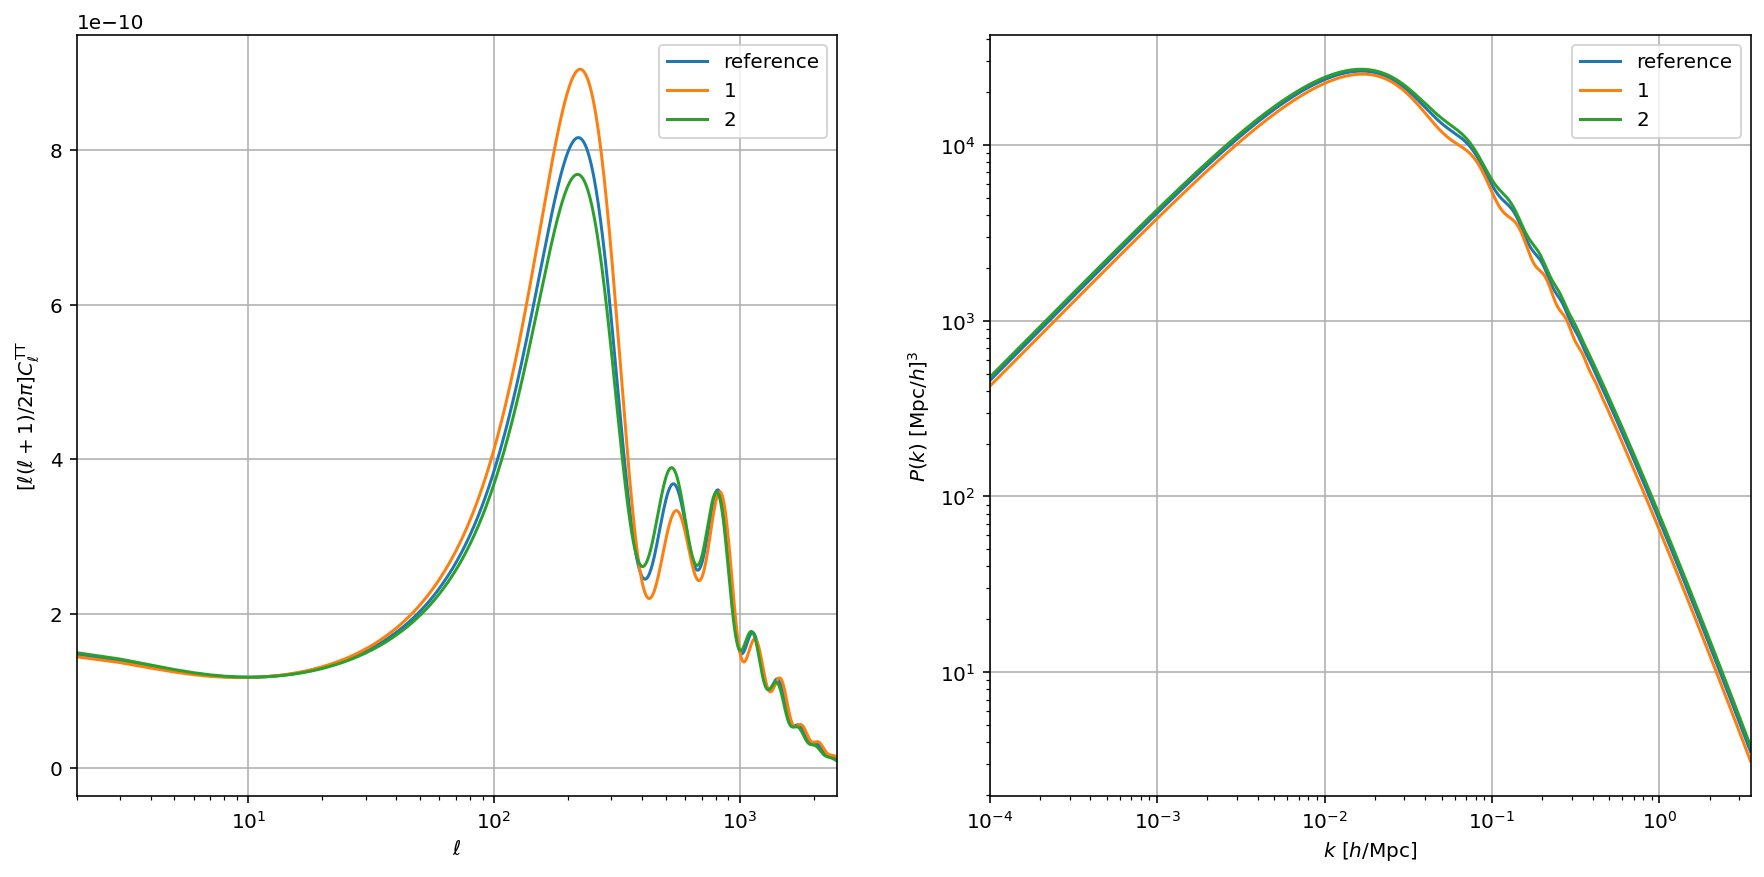

In [111]:
plt.rcParams['figure.figsize'] = (15, 7);

fig, (axCl, axPk) = plt.subplots(1, 2);

axCl.set_xlabel(r'$\ell$')
axCl.set_ylabel(r'$[\ell(\ell+1)/2\pi]  C_\ell^\mathrm{TT}$')
axCl.grid()
axCl.set_xlim(2,2500)

pars0, l0, tt0, Pk0 = simulations0
axCl.semilogx(l0, (tt0)*l0*(l0+1)/2./pi,
                label="reference")
i=1
for pars, l, tt, Pk in simulations:
    axCl.semilogx(l, (tt)*l*(l+1)/2./pi,
                label="%d"%(i))
    i=i+1
#    plt.semilogx(l, tt*l*(l+1)/2./pi,
#                 label="$\Omega_{CDM}=%4.2gh^{-2}, \Omega_b=%4.2gh^{-2}, \Omega_\gamma=%4.2gh^{-2}, \Omega_k=%4.2g, n_s=%4.2g$"%(
#                     pars['omega_cdm'], pars['omega_b'], pars['omega_g'], pars['Omega_k'], pars['n_s']))
axCl.legend()


axPk.set_xlim(kk_h[0], kk_h[-1])
axPk.set_xlabel(r'$k\ [h/\mathrm{Mpc}]$')
axPk.set_ylabel(r'$P(k)\ [\mathrm{Mpc}/h]^3$')
axPk.grid()

pars0, l0, tt0, Pk0 = simulations0
axPk.loglog(kk_h, Pk0, label="reference")
i=1
for pars, l, tt, Pk in simulations:
    axPk.loglog(kk_h, Pk,
                label="%d"%(i))
    i=i+1
#               label="$\Omega_{CDM}=%4.2gh^{-2}, \Omega_b=%4.2gh^{-2}, \Omega_\gamma=%4.2gh^{-2}, \Omega_k=%4.2g, n_s=%4.2g$"%(
#                      pars['omega_cdm'], pars['omega_b'], pars['omega_g'], pars['Omega_k'], pars['n_s']))
axPk.legend()

## Varying amount of baryons

In [112]:
simulations = []

In [113]:
simulations.append(
    run_Class({
        "T_cmb": 2.7255,        # CMB temperature
        "h": 0.6732117,         # Dimensionless reduced Hubble parameter (H_0 / (100km/s/Mpc))
        "omega_b": 0.02238280,  # Reduced baryon density (Omega*h^2)
        "omega_cdm": 0.1201075, # Reduced cold dark matter density (Omega*h^2)
        'Omega_k': 0.,         # Curvature density
        'tau_reio':0.05430842,  # Optical depth of reionization
        'A_s': 2.615e-9,        # Amplitude of prim spectrum
        'n_s': 0.9619,          # Spectrum tilt
        'k_pivot': 0.05         # Pivot scale for A_s,n_s
}) )

In [114]:
simulations.append(
    run_Class({
        "T_cmb": 2.7255,        # CMB temperature
        "h": 0.6732117,         # Dimensionless reduced Hubble parameter (H_0 / (100km/s/Mpc))
        "omega_b": 0.02238280,  # Reduced baryon density (Omega*h^2)
        "omega_cdm": 0.1201075, # Reduced cold dark matter density (Omega*h^2)
        'Omega_k': -0.0,         # Curvature density
        'tau_reio':0.05430842,  # Optical depth of reionization
        'A_s': 2.015e-9,        # Amplitude of prim spectrum
        'n_s': 0.9619,          # Spectrum tilt
        'k_pivot': 0.05         # Pivot scale for A_s,n_s
}) )

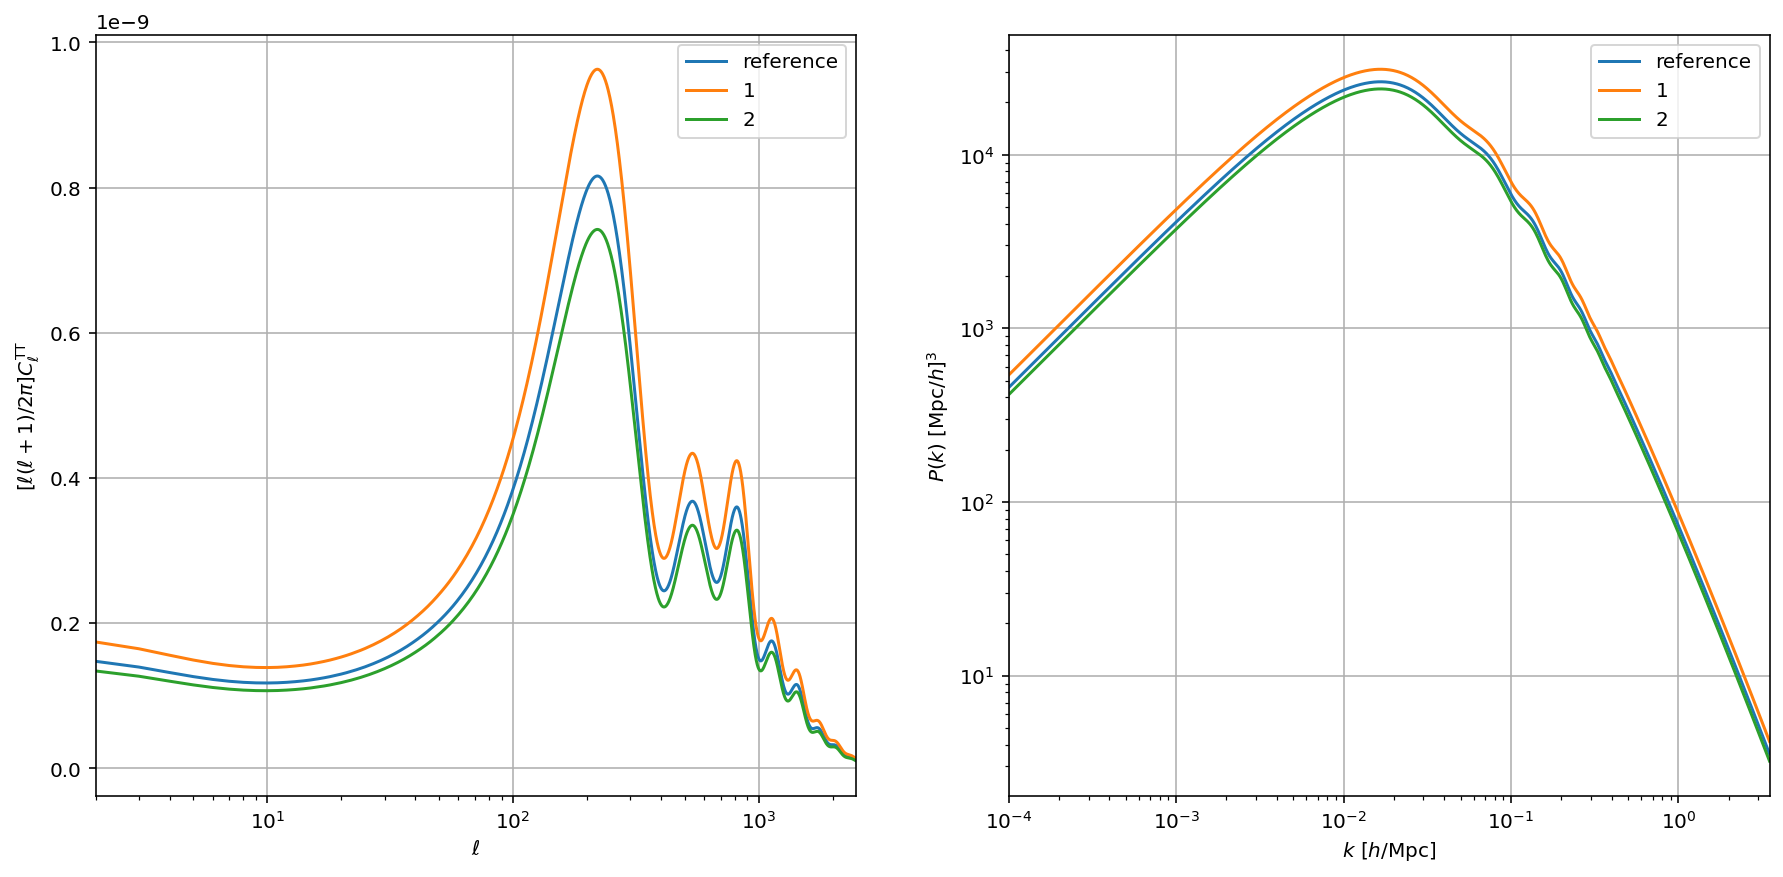

In [115]:
plt.rcParams['figure.figsize'] = (15, 7);

fig, (axCl, axPk) = plt.subplots(1, 2);

axCl.set_xlabel(r'$\ell$')
axCl.set_ylabel(r'$[\ell(\ell+1)/2\pi]  C_\ell^\mathrm{TT}$')
axCl.grid()
axCl.set_xlim(2,2500)

pars0, l0, tt0, Pk0 = simulations0
axCl.semilogx(l0, (tt0)*l0*(l0+1)/2./pi,
                label="reference")
i=1
for pars, l, tt, Pk in simulations:
    axCl.semilogx(l, (tt)*l*(l+1)/2./pi,
                label="%d"%(i))
    i=i+1
#    plt.semilogx(l, tt*l*(l+1)/2./pi,
#                 label="$\Omega_{CDM}=%4.2gh^{-2}, \Omega_b=%4.2gh^{-2}, \Omega_\gamma=%4.2gh^{-2}, \Omega_k=%4.2g, n_s=%4.2g$"%(
#                     pars['omega_cdm'], pars['omega_b'], pars['omega_g'], pars['Omega_k'], pars['n_s']))
axCl.legend()


axPk.set_xlim(kk_h[0], kk_h[-1])
axPk.set_xlabel(r'$k\ [h/\mathrm{Mpc}]$')
axPk.set_ylabel(r'$P(k)\ [\mathrm{Mpc}/h]^3$')
axPk.grid()

pars0, l0, tt0, Pk0 = simulations0
axPk.loglog(kk_h, Pk0, label="reference")
i=1
for pars, l, tt, Pk in simulations:
    axPk.loglog(kk_h, Pk,
                label="%d"%(i))
    i=i+1
#               label="$\Omega_{CDM}=%4.2gh^{-2}, \Omega_b=%4.2gh^{-2}, \Omega_\gamma=%4.2gh^{-2}, \Omega_k=%4.2g, n_s=%4.2g$"%(
#                      pars['omega_cdm'], pars['omega_b'], pars['omega_g'], pars['Omega_k'], pars['n_s']))
axPk.legend()